# rDNA location

In this notebook, we look at the properties of rDNA in the _A. castellanii_ genome.

In [24]:
import os
from typing import Dict, List, Iterable
import numpy as np
import pandas as pd
import scipy.sparse as sp
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
import cooler
import pyfastx as px
import warnings
%config InlineBackend.figure_formats = ['svg']

In [60]:
os.chdir("/home/varogh/Repos/Acastellanii_genome_analysis/")
rdna_c3 = pd.read_csv(
    'data/input/rnammer/C3.gff',
    comment='#',
    sep='\t',
    names=['chrom', 'start', 'end', 'score', 'rDNA'],
    usecols=[0, 3, 4, 5, 8]
)
rdna_neff = pd.read_csv(
    'data/input/rnammer/Neff.gff',
    comment='#',
    sep='\t',
    names=['chrom', 'start', 'end', 'score', 'rDNA'],
    usecols=[0, 3, 4, 5, 8]
)
clr_c3 = cooler.Cooler('data/input/cool/C3.mcool::/resolutions/32000')
clr_neff = cooler.Cooler('data/input/cool/Neff.mcool::/resolutions/32000')

MIN_LEN = 100000
chroms_neff = {x.name: len(x) for x in px.Fasta('data/input/genomes/Neff_assembly.fa') if len(x) > MIN_LEN}
chroms_c3 = {x.name: len(x) for x in px.Fasta('data/input/genomes/C3_assembly.fa') if len(x) > MIN_LEN}
rdna_neff = rdna_neff.loc[rdna_neff.chrom.isin(chroms_neff.keys())].reset_index(drop=True)
rdna_c3 = rdna_c3.loc[rdna_c3.chrom.isin(chroms_c3.keys())].reset_index(drop=True)
rdna_c3

,chrom,start,end,score,rDNA
0,scaffold_5,793360,793474,77.6,8s_rRNA
1,scaffold_34,92229,92343,77.6,8s_rRNA
2,scaffold_34,153536,153650,76.2,8s_rRNA
3,scaffold_34,127532,127646,77.6,8s_rRNA
4,scaffold_1,289507,289621,77.6,8s_rRNA
...,...,...,...,...,...
89,scaffold_20,154628,154742,77.6,8s_rRNA
90,scaffold_29,451668,459956,2988.6,28s_rRNA
91,scaffold_29,437810,446711,669.2,28s_rRNA
92,scaffold_29,462249,464548,1509.9,18s_rRNA


### Genomic location of rDNA
5S rDNA are dispersed throughout the genome. Do they look randomly distributed or follow some kind of rules ?

In [4]:
def get_chrom_prop(chrom: str, pos: int, chroms: Dict[str, int]) -> float:
    """Given a chromosome name and position,
    return the relative distance from telomere (from 0 to 0.5)."""
    try:
        chromlen = chroms[chrom]
        return min(pos / chromlen, (chromlen - pos) / chromlen)
    except KeyError:
        return np.nan

rdna_c3['rel_pos'] = rdna_c3.loc[rdna_c3.rDNA == '8s_rRNA'].apply(
    lambda r: get_chrom_prop(r.chrom, r.start, chroms_c3), axis=1
)
rdna_neff['rel_pos'] = rdna_neff.loc[rdna_neff.rDNA == '8s_rRNA'].apply(
    lambda r: get_chrom_prop(r.chrom, r.start, chroms_neff), axis=1
)

In [5]:
rdna = pd.concat([rdna_c3, rdna_neff], axis=0)

/home/varogh/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/varogh/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, '#rDNA per scaffold / scaffold length')

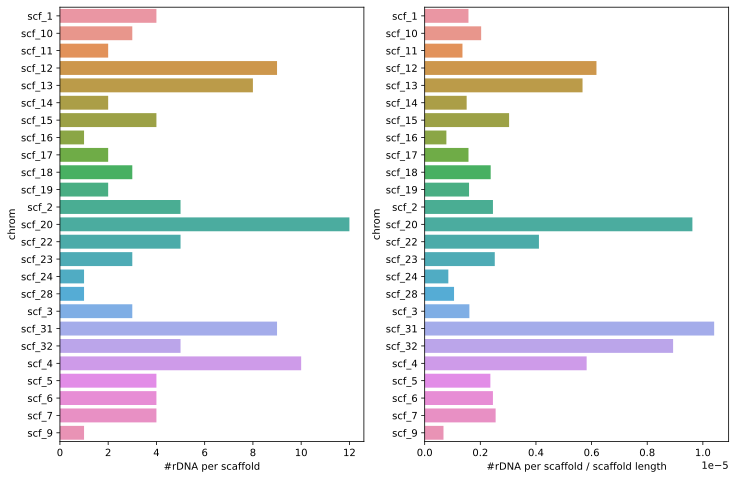

In [26]:
%matplotlib inline
rdna_neff_dist = (
    rdna_neff
    .groupby('chrom')
    .count()['start']
    .reset_index()
    .rename(columns={'start': 'raw'})
)
rdna_neff_dist['norm'] = rdna_neff_dist.apply(lambda x: x.raw / chroms_neff[x.chrom], axis=1)
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
sns.barplot(rdna_neff_dist.raw, rdna_neff_dist.chrom.str.replace('scaffold', 'scf'), ax=ax[0], orient='h')
ax[0].set_xlabel("#rDNA per scaffold")
sns.barplot(rdna_neff_dist.norm, rdna_neff_dist.chrom.str.replace('scaffold', 'scf'), ax=ax[1], orient='h')
ax[1].set_xlabel("#rDNA per scaffold / scaffold length")




Text(0, 0.5, '#rDNA')

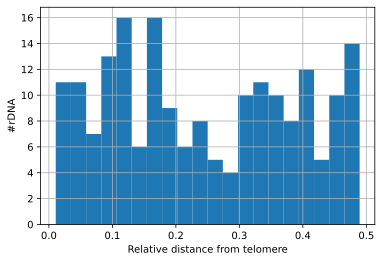

In [27]:
%matplotlib inline
rdna.rel_pos.hist(bins=20)
plt.xlabel("Relative distance from telomere")
plt.ylabel("#rDNA")

In [28]:
boots = []
for i in range(100):
    boots.append(
        rdna_neff.sample(rdna_neff.shape[0], replace=True).apply(
            lambda r: get_chrom_prop(r.chrom, r.start, chroms_neff), axis=1
        ).mean()
    )

In [29]:
p = np.mean(boots > rdna_neff.rel_pos.mean())
print(f"Neff rDNA are not located closer to telomeres than random: p={p}")

Neff rDNA are not located closer to telomeres than random: p=0.2


In [30]:
boots = []
for i in range(100):
    boots.append(
        rdna_c3.sample(rdna_c3.shape[0], replace=True).apply(
            lambda r: get_chrom_prop(r.chrom, r.start, chroms_c3), axis=1
        ).mean()
    )
p = np.mean(boots > rdna_c3.rel_pos.mean())
print(f"C3 rDNA are not located closer to telomeres than random: p={p}")

C3 rDNA are not located closer to telomeres than random: p=0.75


Overall, 5S rDNA is well distributed among chromosomes, and does not have a preference for telomeric or centromeric regions.

### Subtelomeric contacts of rDNA

Is there a strong enrichment of contacts between rDNA and subtelomeric sequences ?

In [98]:
def get_trans_mat(clr: cooler.Cooler, balance: bool=True) -> sp.csr_matrix:
    """Return the whole genome sparse contact
    matrix with all intrachromosomal contacts set to 0
    # NOTE: Broken function
    """
    val = 'balanced' if balance else 'count'
    pixels = clr.matrix(sparse=True, balance=balance, as_pixels=True)[:]
    chrom_ids = clr.bins()[:]["chrom"]
    mask = chrom_ids[pixels['bin1_id']].values == chrom_ids[pixels['bin2_id']].values
    pixels[val][mask] = 0
    pixels = pixels.loc[pixels[val] != 0].reset_index(drop=True)
    mat = sp.coo_matrix((pixels[val], (pixels.bin1_id, pixels.bin2_id)), shape = clr.shape).tocsr()
    
    return mat


def get_rdna_bins(clr: cooler.Cooler, rdna_df: pd.DataFrame, subunit: str) -> List[int]:
    """Returns the list of bin IDs containing the
    target rDNA subunit in input cooler
    """
    bins = np.hstack(
        rdna_df
        .query('rDNA == @subunit')
        .apply(lambda r: f"{r.chrom}:{r.start}-{r.end}", axis=1)
        .apply(clr.extent)
        .apply(lambda x: list(range(x[0], x[1])))
    )
    bins = np.unique(bins)
    return bins


def get_4c_like(clr: cooler.Cooler, bins: Iterable[int], trans_only=True, balance=True):
    "Returns the 4C-like contact profile for given bins"
    if trans_only:
        contacts = get_trans_mat(clr, balance=balance)[bins, :]
    else:
        contacts = clr.matrix(balance=balance, sparse=True)[:].tocsr()[bins, :]
    contacts = np.nanmedian(contacts.toarray(), axis=0)
    
    return contacts


def compute_telo_dist(clr):
    """Compute the number of bins to the closest telomere
    for each bin in the input cooler.
    """
    telos = np.array([clr.extent(name)[1] for name in clr.chromsizes.index.values])
    dists = [np.min(np.abs(telos - p)) for p in range(clr.shape[0])]
    return dists

def plot_rdna_telo_contacts(clr: cooler.Cooler, rdna_df: pd.DataFrame):
    """"End to end visualization of rDNA vs subtelomere contacts"""
    MAXDIST = 1000000 // clr.binsize
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    cols = ['green', 'blue', 'red']
    for i, subunit in enumerate(['18s_rRNA', '28s_rRNA', '8s_rRNA']):
        bins = get_rdna_bins(clr, rdna_df, subunit)
        profile = get_4c_like(clr, bins, trans_only=False, balance=True)
        get_trans_mat(clr)[bins, :].tocoo().col
        dists = np.array(compute_telo_dist(clr))
        bad = (profile == 0) | np.isnan(profile) | (dists > MAXDIST)
        profile = profile[~bad]
        dists = np.array(dists)[~bad]
        #sns.boxplot(dists, np.log10(profile), color='grey', ax=ax[i])
        sns.regplot(
            dists,
            np.log10(profile),
            color=cols[i],
            ax=ax[i],
            lowess=True,
            scatter_kws={'alpha': 0.1, 'color': 'grey', 's': 3}
        )
        ax[i].set_xlim(0, MAXDIST)
        ax[i].set_ylim(
            np.percentile(np.log10(profile), 5),
            np.percentile(np.log10(profile), 95)
        )
        r, p = ss.spearmanr(dists, profile)
        ax[i].set_title(f'{subunit.split("_")[0]} rDNA contacts\nr={r:.2f}, p={p:.1e}')
        ax[i].set_xlabel(f"Distance from telomere [{int(clr.binsize/1000)}kb bins]")
        if not i:
            ax[i].set_ylabel("rDNA contacts")

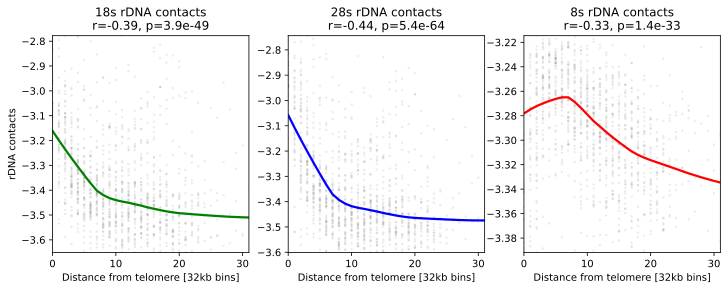

In [95]:
%matplotlib inline
warnings.simplefilter("ignore")
plot_rdna_telo_contacts(clr_c3, rdna_c3)

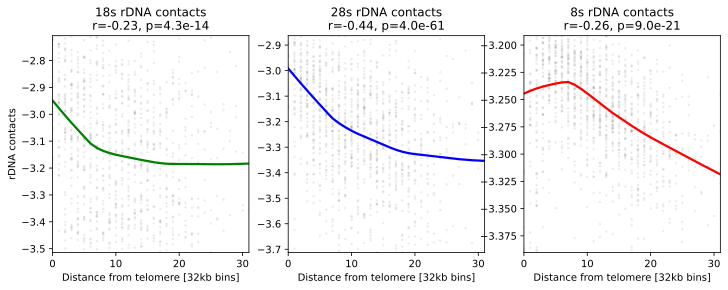

In [99]:
%matplotlib inline
plot_rdna_telo_contacts(clr_neff, rdna_neff)